#<font color='teal'> Fatal Encounters </font>

#### Fatal Encounters is a database of people who have died in connection with an off-duty or working police officer(s). It contains deaths from 2000 to present day and as of 2020, has approximately 30K entries with names, dates, locations of the deceased as well as race, gender, age, location and the policing agency associated with the death. The notebook explores some of the trends in gender, cause, and the locality of these fatalities. The dataset is available here: https://docs.google.com/spreadsheets/d/1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/edit#gid=0
and it must be loaded as a csv file onto your google drive for this notebook to compile correctly.

In [1]:
#load python packages
import os
import io
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
!pip install geopy
import folium
!pip install geopandas
import geopandas as gpd
!pip install contextily
import contextily as ctx
from geopy.geocoders import Nominatim
import datetime as dt
%matplotlib inline
!pip install pygal
!pip install cairosvg
from IPython.core.display import display, HTML
import cairosvg
import pygal 
from pygal.style import Style
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, StandardScaler
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
#import data into google drive, mount google drive and load data
#####import data into google drive if not already there####
#from google.colab import files 
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
from google.colab import drive
###########mount google drive########
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 14.8MB 217kB/s 
     |████████████████████████████████| 6.5MB 47.4MB/s 
     |████████████████████████████████| 18.3MB 63.4MB/s 
     |████████████████████████████████| 133kB 2.6MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp36-none-any.whl size=89548 sha256=1d953ff37b89117dcf1ea9b355d3d470ef214898115d0db58b39a522a5cc364d
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<font color='teal'> Data Loading, cleanup and filling in missing data for Exploratory Data Analysis </font>

In [2]:
###########Load the data##############
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
os.chdir('/content/drive/My Drive/Colab Notebooks/data')
df = pd.read_csv('FatalEncounters10-16-20.csv', engine='python')

df.drop(df.tail(1).index,inplace=True) #Remove the last row, which is a spacer
#####Rename the columns to make them easier to query#####
df=df.rename(columns={'Unique ID':'ID','Subject\'s race':'Race',
                      'Race with imputations':'Imputed_race','Imputation probability':'Imputation_prob','URL of image (PLS NO HOTLINKS)':'URL_image',
                      'Date of injury resulting in death (month/day/year)':'Injury_date','Location of injury (address)':'Injury_loc','Location of death (city)':'city',
                      'State':'st','Location of death (zip code)':'zip','Location of death (county)':'county','Full Address':'Address',
                      'Agency or agencies involved':'Resp_Ag','Cause of death':'Cause','Brief description':'Descrip',
                      'Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS':'NFA_Cause','Intended use of force (Developing)':'Int_force',
                      'Supporting document link':'link','Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS':'Mental_ill'})
#####Drop columns with repeated information#######
df.drop(columns=['Unique ID formula', 'Unique identifier (redundant)', 'Unnamed: 24', 'Unnamed: 25'], inplace=True)
#####Fill in missing zip codes, counties and cities using Nominatim and supplied lat/long data values#######
geolocator = Nominatim(timeout=10, user_agent = "Springboard")
for index, row in df.iterrows(): 
  if (len(str(row.zip).strip('.0'))<4 or pd.isnull(row.zip)): #if there is a null value in zip code or it's too short
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='postcode'
    if key in location.raw['address']: #some of the lat longs don't have a zip code (like neighborhoods)
      df.loc[index,'zip'] = location.raw['address']['postcode']
  if len(str(row.zip))>7:
      print(str('before:')+df.loc[index,'zip']+str('after')+row.zip.astype(str).str[:5])
      df.loc[index,'zip'] = row.zip.astype(str).str[:5]
    #print(df.loc[index,'zip'])
  if pd.isnull(row.city): #if there is a null value in city
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='city'
    if key in location.raw['address']: #some of the lat longs are unincorporated
      df.loc[index,'city'] = location.raw['address']['city']
    #print(df.loc[index,'city'])
  if pd.isnull(row.county): #if there is a null value in county
    x = str(row.Latitude) + str(" ") + str(row.Longitude)
    location = geolocator.geocode(x,addressdetails=True) #look it up in geopy
    key='county'
    if key in location.raw['address']: #to account for no county information
      df.loc[index,'county'] = location.raw['address']['county']
    #print(df.loc[index,'county'])
#####Fill in missing cities using Injury location#######
  if pd.isnull(row.Injury_loc): #if there is a null value in injury location
      df.loc[index,'Injury_loc'] = row.city
      #print(df.loc[index,'Injury_loc'])
#####Fill in missing gender using descriptions in deaths caused by gunshot#######
  if pd.isnull(row.Gender):
      if row.Cause == 'Gunshot':
        s = row.Descrip
        if 'man' in s:
          #print(row.Cause, row.ID, row.Descrip)
          df.loc[index,'Gender'] = 'Male'
        if 'woman' in s:
          #print(row.Cause, row.ID, row.Descrip)
          df.loc[index,'Gender'] = 'Female'
#####Replace non-numeric values in Age with numeric estimates, and fill in missing values with median###########
temp=df.Age.fillna("0")
temp2 = np.where(temp.str.contains("months"))
for i in temp2:
  df.loc[i,'Age']= pd.to_numeric(temp[i].str.strip('months'))/12
  dict = {'20s':'25','30s':'35','40s':'45','50s':'55','60s':'65','70s':'75','20s-30s':'30','18-25':'21.5','40-50':'45','3 days':3/365,'46/53':np.nan} #Values to re-map
df.replace({"Age": dict}, inplace=True)
df['Age']=pd.to_numeric(df.Age, errors='coerce')
#####Format zipcodes to first 5 digits, add zeros, remove float part######
df.zip = df.zip.astype(str).str.replace(' ', '').str[:5].str.strip('.').str.zfill(5)
#####Fill in any remaining missing values with Nans###############
df.fillna(np.nan, inplace=True)
###Convert injury date to datetime 
df['Injury_date']=pd.to_datetime(df.Injury_date)
#Remove commas from Latitude
df.Latitude.replace(',','', regex=True, inplace=True)

#<font color='teal'> Summary of Exploratory Data Analysis</font>

Results show a large number of deaths occuring at 2347 S. Michigan Avenue in Chicago occurring on Feb. 19, 2003, which upon further investigation, appears to have been related to a single stampede in a night club caused by a police officer using pepper spray inside the building. There was also a large number of deaths occuring on June 25, 2020, related to a vehicle crash after fleeing a border control check, and large number on March 28, 2014 related to a reckless driving incident. The missing values for Age were not imputed from a mean to avoid putting abnormal values in its distribution for the exploratory data analysis portion of this study.

#<font color='teal'> Age of fatal encounters </font>
The most common age to be killed is 22, with an average age of 35 years old. The youngest person was 3 days old, and was killed after an emergency delivery following a vehicle crash which killed his mother, a passenger in the car. The oldest was 107, who died when police returned fire at a residence.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


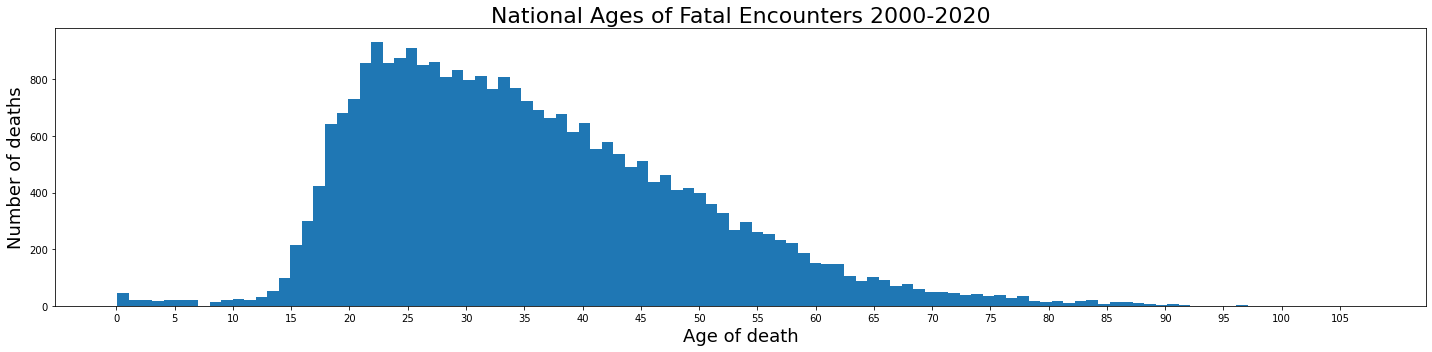

In [3]:
Ageplot=plt.figure(figsize=(20,5))
plt.hist(df.Age.astype('float'),bins=108) #there are 108 unique values
plt.xlabel('Age of death', fontsize=18)
plt.ylabel('Number of deaths', fontsize=18)
plt.title('National Ages of Fatal Encounters 2000-2020', fontsize=22)
sns.set_style("whitegrid")
plt.xticks(range(0,110,5))
plt.tight_layout()
Ageplot.show()
#from google.colab import files
#Ageplot.savefig("Age.jpg")
#files.download("Age.jpg") 
plt.show()

#<font color='teal'> Gender of fatal encounters </font>
Deaths are by far mostly male in comparison to females or transgender individuals.

In [85]:
custom_style = Style(
    legend_font_size = 12,
    title_font_size = 14,
    value_font_size=12)
Genderplot = pygal.Pie(width=600, height=600, style=custom_style, legend_box_size=2, margin=2, title='Genders of Fatal Encounters', print_values=True)
genders=['Male','Female','Transgender']
values = df.Gender.value_counts()

for row in range(0,3):
    sex = genders[row]
    num = values[genders[row]]
    Genderplot.add(sex,num)  
Genderplot.value_formatter = lambda x: "{:.0f}".format(x)
Genderplot.render_in_browser()
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=Genderplot.render(is_unicode=True)))
#from google.colab import files
#Genderplot.render_to_png('Gender.png')
#files.download("Gender.png") 

file:///tmp/tmp_9u08n70.html


#<font color='teal'> Cause of fatal encounters for males </font>
For males, the most common cause of death is by gunshot.

In [84]:
custom_style = Style(
    legend_font_size = 12,
    title_font_size = 14,
    value_font_size=12)
MaleCODPlot = pygal.Pie(width=600, height=600, margin=2, style=custom_style, legend_box_size=10
                              , title='Male Cause of Fatal Encounter', print_values=True, truncate_legend=50)
causes=['Gunshot','Vehicle','Tasered','Medical emergency','Asphyxiated/Restrained','Beaten/Bludgeoned with instrument','Drowned','Drug overdose','Other']
values = df.loc[df['Gender'] == 'Male'].Cause.value_counts()[:8]
other = np.sum(df.loc[df['Gender'] == 'Male'].Cause.isin(['Undetermined','Fall from a height','Chemical agent/Pepper Spray',
                                                                 'Burned/Smoke inhalation','Stabbed','Unknown']))
values.at['Other'] = other

for row in range(0,9):
    cause = causes[row]
    num = values[causes[row]]
    MaleCODPlot.add(cause,num)  
MaleCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
MaleCODPlot.render_in_browser()
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=MaleCODPlot.render(is_unicode=True)))
#from google.colab import files
#MaleCODPlot.render_to_png('MaleCOD.png')
#files.download("MaleCOD.png") 

file:///tmp/tmpwv_5uffz.html


#<font color='teal'> Cause of fatal encounters for females </font>
For females, the most common cause of death is by means of a vehicle.

In [83]:
custom_style = Style(
    legend_font_size = 12,
    title_font_size = 14,
    value_font_size=12)
FemaleCODPlot = pygal.Pie(width=600, height=600, style=custom_style, legend_box_size=10
                              , title='Female Causes of Fatal Encounters', print_values=True, truncate_legend=50)
causes=['Vehicle','Gunshot','Medical emergency','Drug overdose','Tasered','Drowned','Stabbed','Asphyxiated/Restrained']
values = df.loc[df['Gender'] == 'Female'].Cause.value_counts()
other = np.sum(df.loc[df['Gender'] == 'Female'].Cause.isin(['Undetermined','Beaten/Bludgeoned with instrument','Fell from a height','Chemical agent/Pepper Spray',
                                                                 'Burned/Smoke inhalation','Stabbed','Undetermined','Pursuit','Other']))
values.at['Other'] = other

for row in range(0,8):
    cause = causes[row]
    num = values[causes[row]]
    FemaleCODPlot.add(cause,num)  
FemaleCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
FemaleCODPlot.render_in_browser()
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=FemaleCODPlot.render(is_unicode=True)))
#from google.colab import files
#FemaleCODPlot.render_to_png('FemaleCOD.png')
#files.download("FemaleCOD.png") 

file:///tmp/tmp4ljfwhg_.html


#<font color='teal'> Cause of fatal encounters for Transgender individuals </font>
For transgender individuals, the most common cause of death is by gunshot.

In [7]:
custom_style = Style(
    legend_font_size = 2,
    title_font_size = 5,
    value_font_size=4)
TransgenderCODPlot = pygal.Pie(width=200, height=200, style=custom_style, legend_box_size=10
                              , title='Transgender Individuals Causes of Fatal Encounters', print_values=True, truncate_legend=50)
causes=['Vehicle','Gunshot','Medical emergency','Tasered','Asphyxiated/Restrained','Beaten/Bludgeoned with instrument','Undetermined']
values = df.loc[df['Gender'] == 'Transgender'].Cause.value_counts()

for row in range(0,7):
    cause = causes[row]
    num = values[causes[row]]
    TransgenderCODPlot.add(cause,num)  
TransgenderCODPlot.value_formatter = lambda x: "{:.0f}".format(x)
TransgenderCODPlot.render() 
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=TransgenderCODPlot.render(is_unicode=True)))
#from google.colab import files
#TransgenderCODPlot.render_to_png('TransgenderCOD.png')
#files.download("TransgenderCOD.png") 

#<font color='teal'> Locations of fatal encounters by gunshot </font>
##Deaths from gunshot occur in every state.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


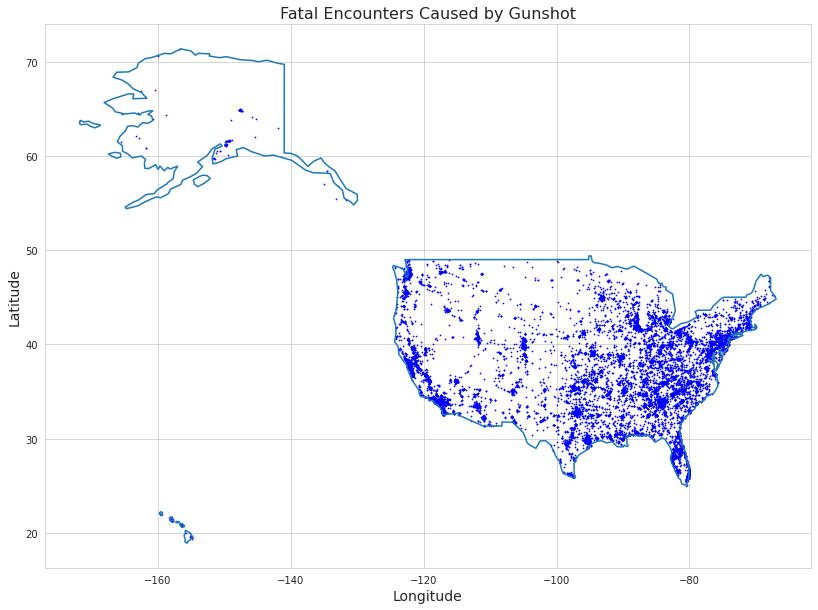

In [8]:
Gun = df[df['Cause'] == 'Gunshot']
Gun.Latitude = Gun.Latitude.replace(', ','', regex=True) #Fix a typo in the data
gdf_us = gpd.GeoDataFrame(Gun, geometry=gpd.points_from_xy(Gun.Longitude, Gun.Latitude))
gdf_us = gdf_us.set_crs("EPSG:4326") #Used by google maps, which was used to locate the deaths in the original data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:4326')#convert map to correct crs to match data
usa = world.query('name == "United States of America"') #just US portion of world map
ax = usa.boundary.plot(figsize=(20,10))
gdf_us.plot(ax=ax, markersize=0.5 ,color='blue', figsize=(19,5))
USMap=plt.plot(figsize=(10,20))
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Fatal Encounters Caused by Gunshot', fontsize=16)
plt.show()
#from google.colab import files
#plt.savefig('USMap.png')
#files.download("USMap.png") 

### The highest number of these deaths occur in California, followed by Texas, then Florida and Georgia.

In [88]:
custom_style = Style(
    legend_font_size = 12,
    title_font_size = 14,
    value_font_size=12)
GunPlot = pygal.Pie(width=600, height=600, style=custom_style, legend_box_size=10
                              , title='State Distribution of Fatal Encounters by Gunshot', print_values=True, truncate_legend=50)
states=['CA','TX','FL','GA','AZ','PA','OH','IL','MO','CO','Other']
values = Gun.st.value_counts()
#df[df["column"].isin(["value"]) == False]
other = np.sum([Gun['st'].isin(states) == False])
values.at['Other'] = other
    #cause = causes[row]
    #num = values[causes[row]]
for row in range(0,11):
    state = states[row]
    num = values[states[row]]
    GunPlot.add(state,num)  
GunPlot.value_formatter = lambda x: "{:.0f}".format(x)
GunPlot.render_in_browser()
no_wrap_div = '<div style="white-space: nowrap; overflow-x: auto">{}{}</div>' 
html_pygal = u"""
    <!DOCTYPE html>
    <html>
        <head>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
            <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
        </head>
        <body><figure>{pygal_render}</figure></body>
    </html>
"""
HTML(html_pygal.format(pygal_render=GunPlot.render(is_unicode=True)))
#from google.colab import files
#GunPlot.render_to_png('GunState.png')
#files.download("GunState.png") 

file:///tmp/tmphrnre2er.html


#<font color='teal'> Locations of fatal encounters by gunshot in California </font>
In California, the highest density of deaths occurs near Los Angelos and the surrounding area, followed by those occuring in major cities and along California State Route 99.

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

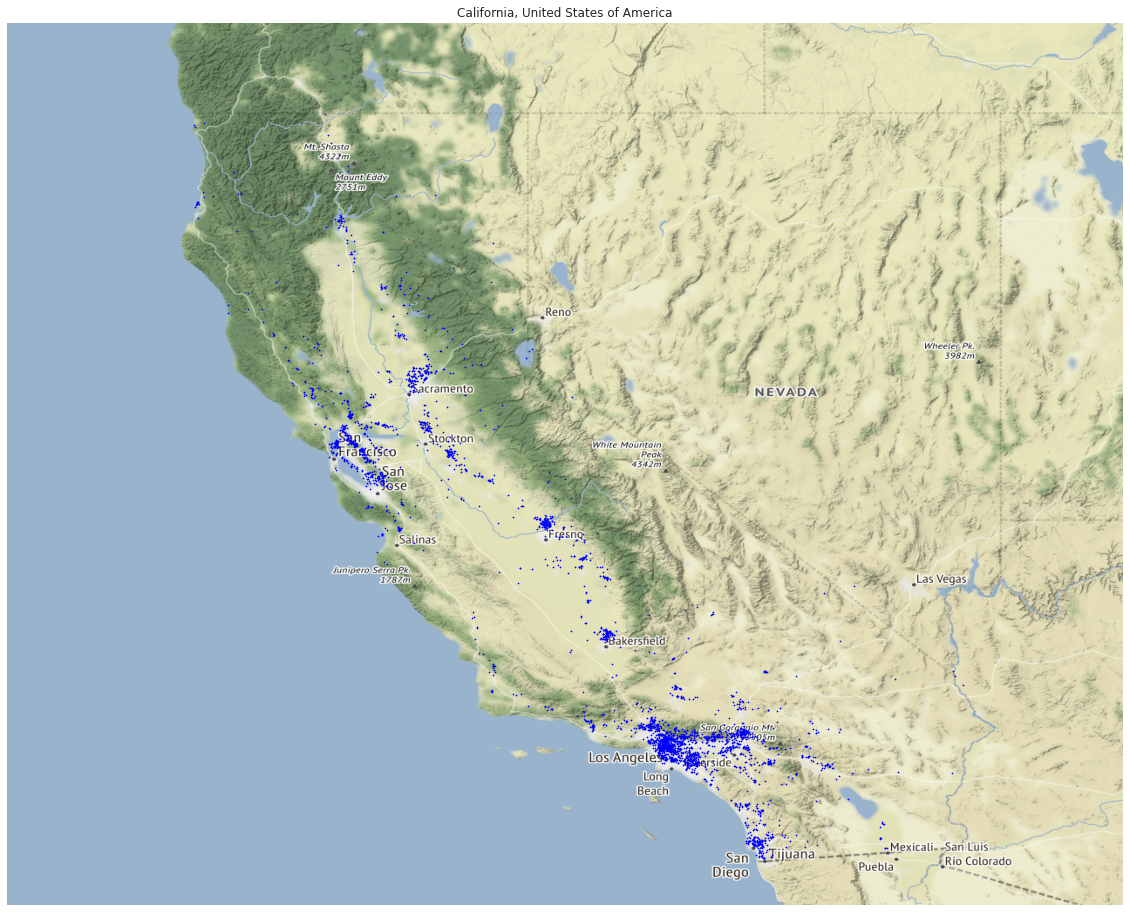

In [89]:
CA = Gun[Gun.st=='CA']
Lat = CA.Latitude
Long = CA.Longitude
CA.Latitude = Lat
CA.Longitude = Long
gdf = gpd.GeoDataFrame(CA, geometry=gpd.points_from_xy(CA.Longitude, CA.Latitude))
gdf = gdf.set_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(20, 20))
loc = ctx.Place("California", zoom_adjust=0)  # zoom_adjust modifies the auto-zoom
gdf.plot(ax=ax, markersize=0.5 ,color='blue')
ctx.plot_map(loc,ax=ax)
#from google.colab import files
#plt.savefig('CAMap.png')
#files.download("CAMap.png") 

#<font color='teal'> Locations of fatal encounters by gunshot in Texas </font>
In Texas, the highest density of deaths occurs near major cities.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher

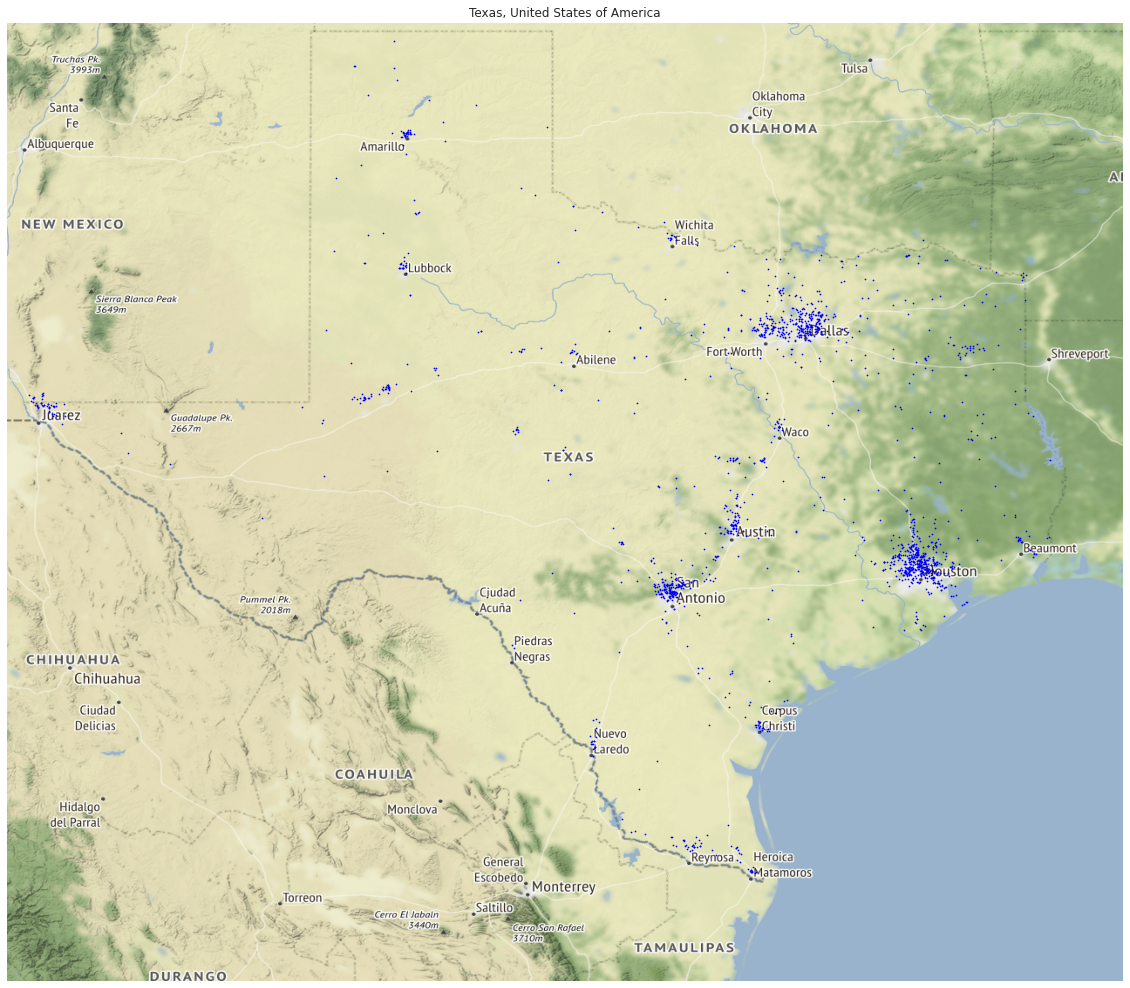

In [11]:
TX = Gun[Gun.st=='TX']
#Manual fixes to erroneous lat longs
Lat = TX.Latitude
Long = TX.Longitude
Lat.iloc[1138] = 29.4841368
Lat.iloc[1140] = 32.8068085
Long.iloc[1138] = -95.1562599
Long.iloc[1140] = -96.6788695
TX.Latitude = Lat
TX.Longitude = Long
gdf = gpd.GeoDataFrame(TX, geometry=gpd.points_from_xy(TX.Longitude, TX.Latitude))
gdf = gdf.set_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(20, 20))
loc = ctx.Place("Texas", zoom_adjust=0)
gdf.plot(ax=ax, markersize=0.5 ,color='blue')
ctx.plot_map(loc,ax=ax)
#from google.colab import files
#plt.savefig('TXMap.png')
#files.download("TXMap.png") 

#<font color='teal'> Timeline of Fatal Encounters nationwide </font>
The yearly number of fatal encounters has increased nearly linearly from 2000 through 2019, with deaths caused by gunshot being the leading factor.

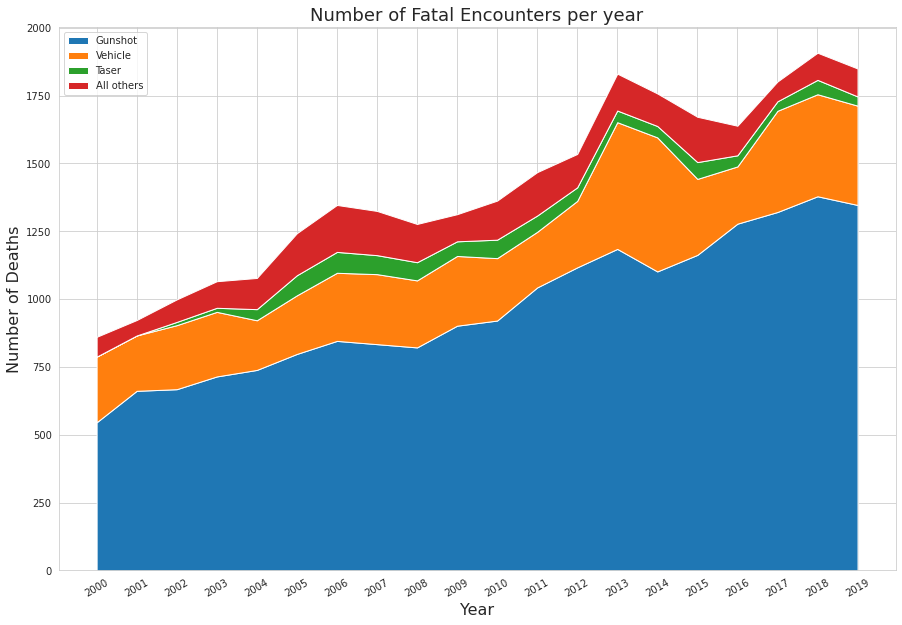

In [93]:
df['Year'] = pd.to_datetime(df.Injury_date, format='%m/%d/%Y').dt.year
Years_unique=df.Year.unique()[:20] #exclude 2020 because it's an incomplete year as of september
Yearlist=[]
Gunlist=[]
Vehiclelist=[]
Taserlist=[]
Otherlist=[]
for i in Years_unique:
  Year_sum=np.sum((df.Year==i)==True)
  Yearlist.append(Year_sum)
  Gunlist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
  Vehiclelist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
  Taserlist.append(df.loc[(df['Year'] == i) & (df['Cause'] == 'Tasered'), 'Cause'].count())
  Otherlist.append(df.loc[(df['Year'] == i) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())
fig, ax = plt.subplots(figsize=(15,10))
sns.set_style("whitegrid")
plt.stackplot(Years_unique, Gunlist, Vehiclelist, Taserlist, Otherlist, labels=['Gunshot','Vehicle','Taser','All others'])
plt.xticks(range(2000,2020))
plt.ylabel('Number of Deaths', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Number of Fatal Encounters per year', fontsize=18)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.legend(loc='upper left')
plt.show()
#from google.colab import files
#plt.savefig("YearByCause.png")
#files.download("YearByCause.png") 

#<font color='teal'> Agencies responsible for the highest number of Fatal Encounters nationwide </font>
The top agencies responsible for the most deaths in the US are associated with some, but not all of the largest cities with two of the top five in Los Angelos, CA.

In [95]:
df['Resp_Ag'].value_counts()[:5]

Los Angeles Police Department              470
Chicago Police Department                  430
Los Angeles County Sheriff's Department    350
City of New York Police Department         331
Houston Police Department                  316
Name: Resp_Ag, dtype: int64

## However those agencies are not responsible for the overall increasing trend seen over 2000-2020:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

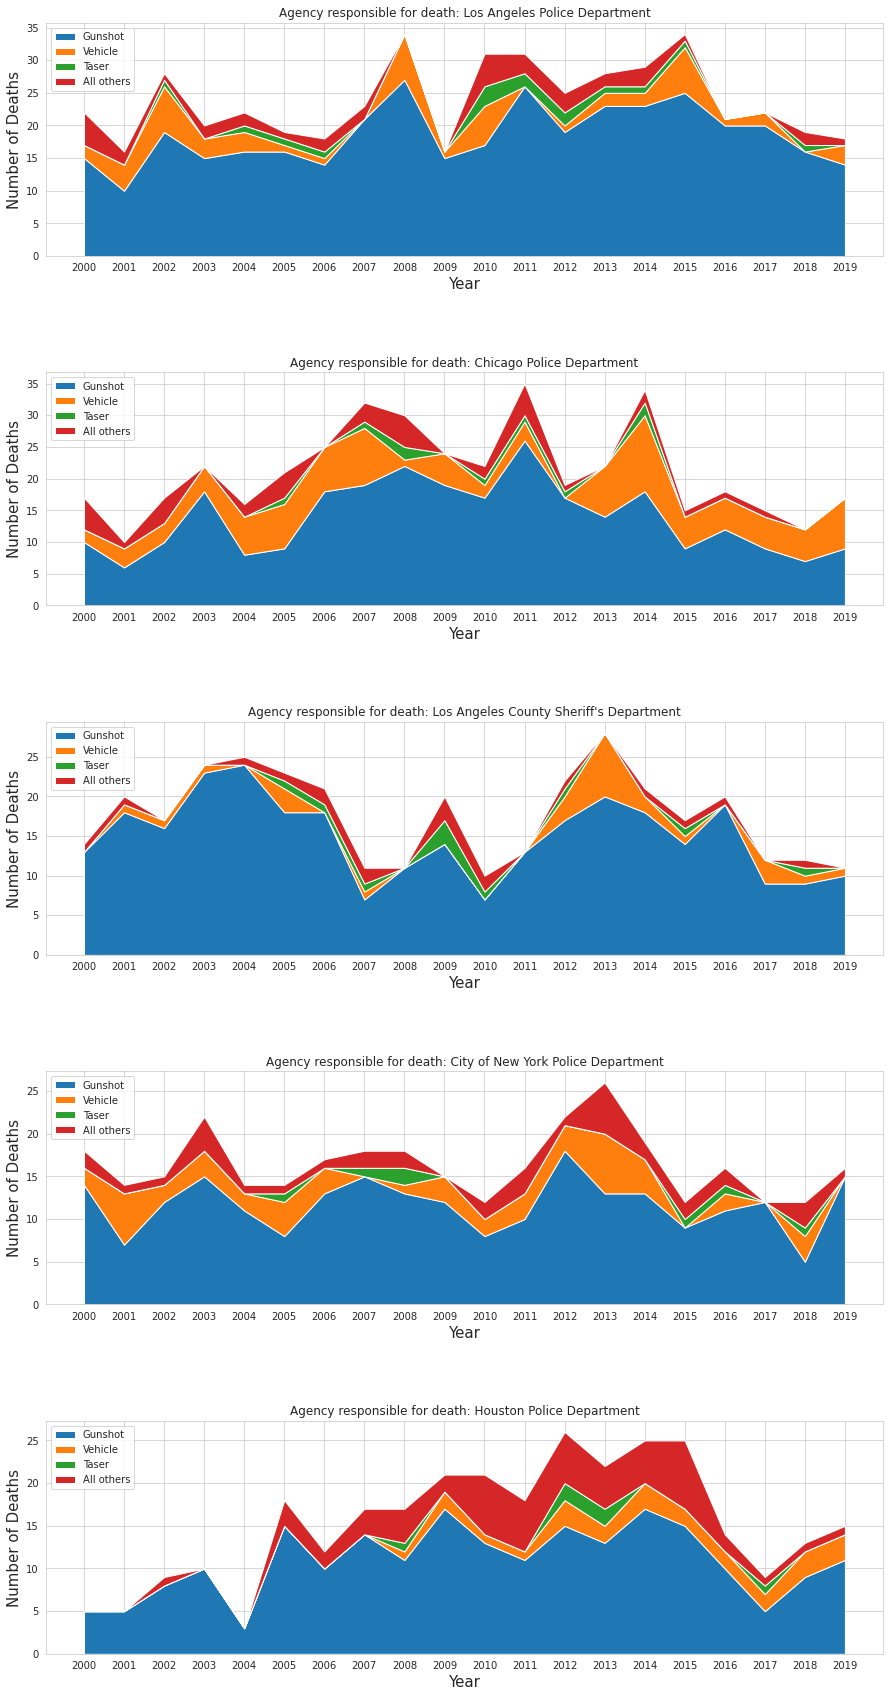

In [102]:
dfLAPD = df.loc[(df['Resp_Ag'] == 'Los Angeles Police Department')] #Create a df for just LAPD
dfCHID = df.loc[(df['Resp_Ag'] == 'Chicago Police Department')] #Create a df for just CHID
dfLASD = df.loc[(df['Resp_Ag'] == 'Los Angeles County Sheriff\'s Department')] #Create a df for just LASD
dfNYPD = df.loc[(df['Resp_Ag'] == 'City of New York Police Department')] #Create a df for just NYPD
dfHPD = df.loc[(df['Resp_Ag'] == 'Houston Police Department')] #Create a df for just HPD
RESP = ('LAPD','CHID','LASD','NYPD','HPD') #list of police departments
RESP_long = ('Los Angeles Police Department','Chicago Police Department','Los Angeles County Sheriff\'s Department','City of New York Police Department','Houston Police Department')
Years = pd.to_datetime(df.Year)
Years_unique=df.Year.unique()[:20] #exclude 2020 because it's an incomplete year as of september
###Initialize lists
Yearlist = []
Guns= [[] for _ in range(5)]
Veh= [[] for _ in range(5)]
Tas= [[] for _ in range(5)]
Oth= [[] for _ in range(5)]

for i in Years_unique:
  Year_sum=np.sum((df.Year==i)==True)
  Yearlist.append(Year_sum)
for i in range(0,5):
  for j in Years_unique:
    Guns[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
    Veh[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
    Tas[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] == 'Tasered'), 'Cause'].count())
    Oth[i].append(df.loc[(df['Year'] == j) & (df['Resp_Ag'] == RESP_long[i]) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())

fig, axs = plt.subplots(5,figsize=(15,30))
sns.set_style("whitegrid")
for k in range(0,5):
  axs[k].stackplot(Years_unique, Guns[k], Veh[k], Tas[k], Oth[k], labels=['Gunshot','Vehicle','Taser','All others'])
  axs[k].title.set_text('Agency responsible for death: ' + str(RESP_long[k]))
  axs[k].set_ylabel('Number of Deaths', fontsize=15)
  axs[k].set_xlabel('Year', fontsize=15)
  axs[k].legend(loc="upper left")
plt.setp(axs, xticks=range(2000,2020))
#from google.colab import files
#plt.savefig("YearByCauseByAgency.png")
#files.download("YearByCauseByAgency.png") 
plt.subplots_adjust(hspace = 0.5)
plt.show()

#<font color='teal'> Timeline of Fatal Encounters nationwide in 2020 </font>
## It is not clear if the recent attention towards the deaths of unarmed Black individuals has impacted the number of fatal gun encounters.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

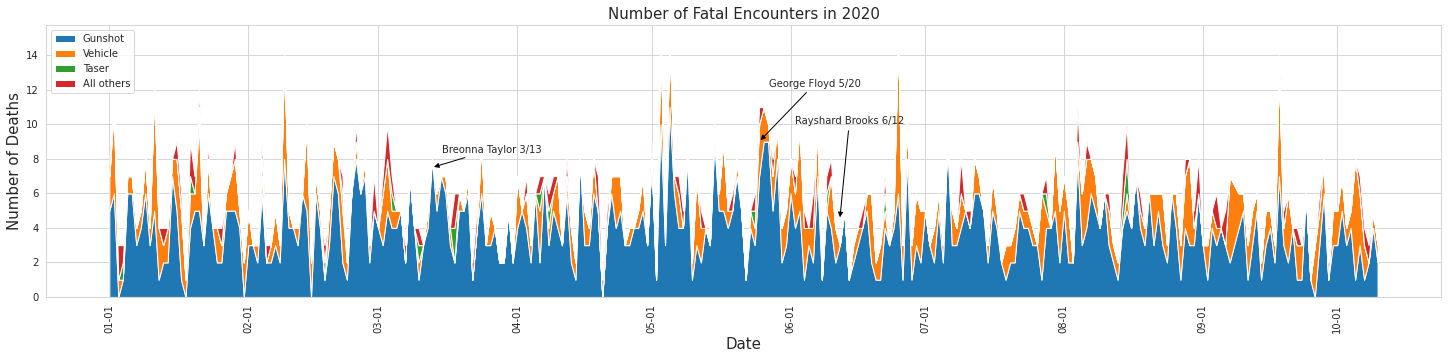

In [103]:
df2020 = df.loc[(df['Year'] == 2020)] #Create a df for just 2020
dates=df2020.Injury_date.unique()
datelist=[]
Gunlist=[]
Vehiclelist=[]
Taserlist=[]
Otherlist=[]
for i in dates:
  date_sum=np.sum((df.Injury_date==i)==True)
  datelist.append(date_sum)
  Gunlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Gunshot'), 'Cause'].count())
  Vehiclelist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Vehicle'), 'Cause'].count())
  Taserlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] == 'Tasered'), 'Cause'].count())
  Otherlist.append(df.loc[(df['Injury_date'] == i) & (df['Cause'] != 'Gunshot') & (df['Cause'] != 'Vehicle') & (df['Cause'] != 'Taser'), 'Cause'].count())
  dates = pd.to_datetime(dates, infer_datetime_format=True)
fig, ax = plt.subplots(figsize=(25,5))
sns.set_style("whitegrid")
plt.stackplot(dates, Gunlist, Vehiclelist, Taserlist, Otherlist, labels=['Gunshot','Vehicle','Taser','All others'])
plt.ylabel('Number of Deaths', fontsize=15)
ax.xaxis_date()
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date', fontsize=15)
plt.title('Number of Fatal Encounters in 2020', fontsize=15)
ax.xaxis.set_tick_params(rotation=90, labelsize=10)
plt.legend(loc='upper left')
ax.get_xlim()
ax.annotate("George Floyd 5/20",
            xy=(mdates.date2num(dt.datetime(2020, 5, 25)),9), xytext=(10, 55), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
ax.annotate("Breonna Taylor 3/13",
            xy=(mdates.date2num(dt.datetime(2020, 3, 13)),7.5), xytext=(10, 15), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
ax.annotate("Rayshard Brooks 6/12",
            xy=(mdates.date2num(dt.datetime(2020, 6, 12)),4.5), xytext=(-45, 95), 
            textcoords='offset points', arrowprops={'arrowstyle':'-|>', 'color':'black'}
            )
#from google.colab import files
#plt.savefig("2020ByCause.png")
#files.download("2020ByCause.png")
plt.show()

#<font color='teal'> Is it possible to model deaths occuring by gunshot and use the weights to understand what the underlying factors are? </font>

## Data cleanup for modeling

In [3]:
df['Year'] = pd.to_datetime(df.Injury_date, format='%m/%d/%Y').dt.year #Create Year for analysis
df.Latitude = df.Latitude.astype(float)
df.zip.replace('00nan',np.nan,inplace=True)
df.zip=df.zip.astype(float)
df.Age=df["Age"].fillna(value=df["Age"].mean()) #Fill in missing values with mean
df.Gender=df['Gender'].fillna(value="unknown")
df.Injury_loc=df['Injury_loc'].fillna(value='unknown')
df.Resp_Ag=df['Resp_Ag'].fillna(value='unknown')
df.city=df['city'].fillna(value="unknown")
df.Imputed_race=df['Imputed_race'].fillna(value=df['Race'])
X=df[['Age','Gender','Imputed_race','county','Year']].copy() #Create independent variables
X = pd.get_dummies(X, drop_first=True) #Create dummy variables for categorical variables
y=(df['Cause']=='Gunshot')*1 #Dependent variable
###Oversample to correct imbalance issue####
oversample = SMOTE()
cols=X.columns
X, y = oversample.fit_resample(X, y)
X = pd.DataFrame(X, columns = cols)
####Create test and training set for logistic regression####
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=123)
X_train=scale(X_train) #Scale data
X_test=scale(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Use weighted logistic regression with GridSearchCV and oversampling the minority class to classify the deaths into 1=caused by gunshot and 0=caused by other means shows that the recall is low for the test results at only 0.06 for predicting the minority class (oversampled with SMOTE):

#<font color='teal'> Baseline logistic regression model

In [17]:
clf = LogisticRegression(max_iter=10000)

w=[{0:73,1:27},{0:60,1:40}, {0:50,1:50}, 
     {0:80,1:20}, {0:90,1:10} ]
hyperparam_grid = {"class_weight": w, 'C':[0.001, 0.1, 1, 10, 100]}

grid = GridSearchCV(clf,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)

grid.fit(X_train,y_train)
y_pred = grid.predict(X_train)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')
print(grid.best_params_)
print(classification_report(y_train, y_pred, zero_division=1))
y_pred = grid.predict(X_test)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, zero_division=1))

Best parameter (CV score=0.690):
Best score: 0.6899135053049822 with param: {'C': 100, 'class_weight': {0: 50, 1: 50}}
{'C': 100, 'class_weight': {0: 50, 1: 50}}
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     12217
           1       0.66      0.69      0.68     12351

    accuracy                           0.67     24568
   macro avg       0.67      0.67      0.67     24568
weighted avg       0.67      0.67      0.67     24568

Test Accuracy Score: 0.5199023199023199
Test Confusion Matrix: 
[[ 525 7732]
 [ 132 7991]]
Test Area Under Curve: 0.5236661305183202
              precision    recall  f1-score   support

           0       0.80      0.06      0.12      8257
           1       0.51      0.98      0.67      8123

    accuracy                           0.52     16380
   macro avg       0.65      0.52      0.39     16380
weighted avg       0.65      0.52      0.39     16380



# The highest weighted (both positive and negative) features are all related to locations. 
##A positive weight means that a feature will contribute towards modeling a 1=gunshot related death, and a negative weight means that a feature contributes towards a 0=non-gunshot related death.

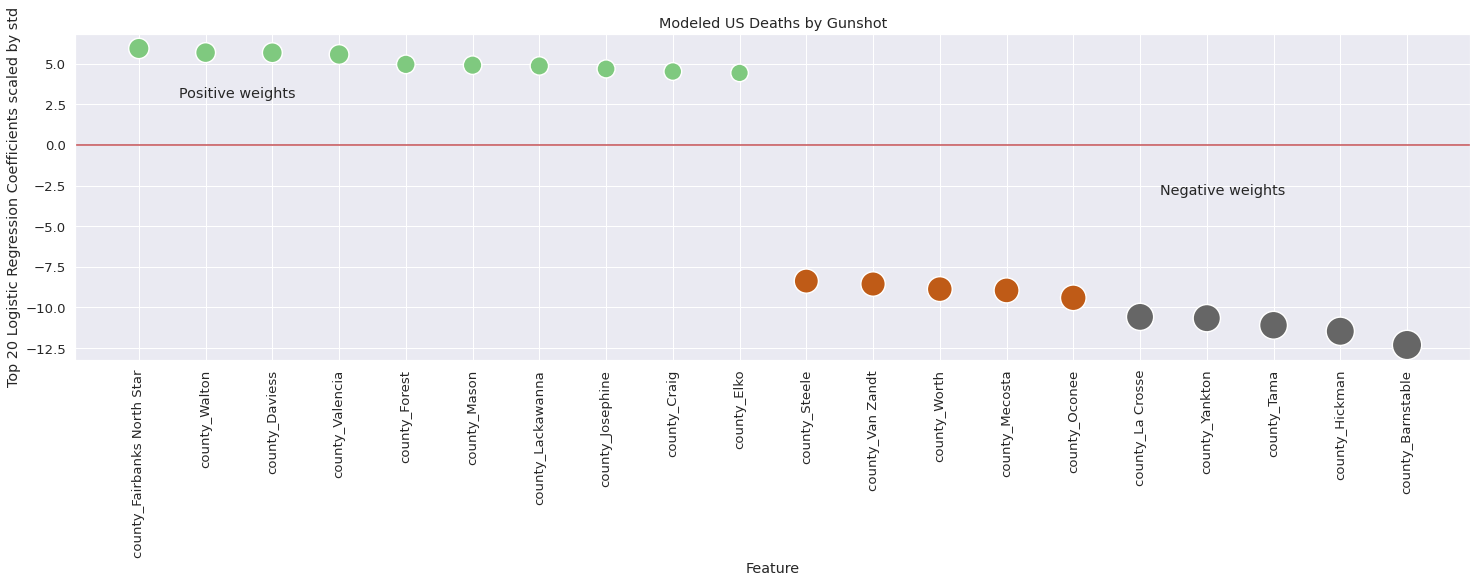

In [23]:
coefficients=grid.best_estimator_.coef_.tolist()
features=X.columns
US_df=pd.DataFrame()
US_df['Feature'] = features
US_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
US_df = US_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([US_df.head(10), US_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 6))
sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*70),palette='Accent_r',legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.3,-2), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(15,-8), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled US Deaths by Gunshot")
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

#<font color='teal'>Can we improve these results by grouping into clusters via K-Means and run the regression on the individual clusters? </font>
###Yes, but only slightly. The following shows that the elbow point for sum of squared error (sse) occurs at 3 clusters:

#<font color='teal'> Expanded modeling

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


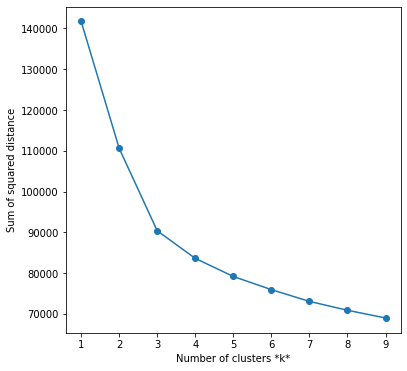

In [4]:
KM_X=df[['Age','Gender','Imputed_race','county','Year']].copy()
KM_y=(df['Cause']=='Gunshot')*1
KM_X = pd.get_dummies(KM_X, drop_first=True)
cols=KM_X.columns
oversample = SMOTE() #Oversampling the minority class
KM_X, KM_y = oversample.fit_resample(KM_X, KM_y)
KM_X = pd.DataFrame(KM_X, columns = cols)
scaler = StandardScaler()
numer = KM_X[['Age', 'Year']]
numer = pd.DataFrame(scaler.fit_transform(numer))
numer.columns = ['Age', 'Year']
cater = KM_X.drop(['Age', 'Year'], axis=1)
KM_X = pd.concat([numer, cater], axis=1, join='inner')
sse = []

list_k = list(range(1, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(KM_X)
    sse.append(km.inertia_)
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.show()

## Next, we can run KMeans followed by logistic regression on each of the three clusters.

In [5]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(KM_X)
clusters = kmeans.predict(KM_X)
KM_X["Cluster"] = clusters
KM_y = pd.DataFrame(KM_y)
KM_y0=KM_y.loc[KM_X[KM_X['Cluster']==0].index,:]
KM_y1=KM_y.loc[KM_X[KM_X['Cluster']==1].index,:]
KM_y2=KM_y.loc[KM_X[KM_X['Cluster']==2].index,:]
cluster0=KM_X[KM_X.Cluster==0]
cluster1=KM_X[KM_X.Cluster==1]
cluster2=KM_X[KM_X.Cluster==2]

## Start with logistic regression on cluster 0/2 increases recall in the minority class test case from 0.06 to 0.25:

In [6]:
#Try logistic regression on cluster0
w=[{0:73,1:27},{0:60,1:40}, {0:50,1:50}, 
     {0:80,1:20}, {0:90,1:10} ]
hyperparam_grid = {"class_weight": w, 'C':[0.001, 0.1, 1, 10, 100]}
X_trainc0, X_testc0, y_trainc0, y_testc0 = train_test_split(cluster0,KM_y0,test_size=0.4,random_state=123)
X_trainc0=scale(X_trainc0)
X_testc0=scale(X_testc0)
clf_c0=LogisticRegression(max_iter=10000)
grid_c0 = GridSearchCV(clf_c0,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid_c0.fit(X_trainc0,y_trainc0)
y_predc0train = grid_c0.predict(X_trainc0)
print(grid_c0.best_params_)
print(classification_report(y_trainc0, y_predc0train, zero_division=1))
y_predc0test = grid_c0.predict(X_testc0)
print(f'Test Accuracy Score: {accuracy_score(y_testc0,y_predc0test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_testc0, y_predc0test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_testc0, y_predc0test)}')
print(classification_report(y_testc0, y_predc0test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'class_weight': {0: 60, 1: 40}}
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      5072
           1       0.79      0.57      0.66      4955

    accuracy                           0.71     10027
   macro avg       0.73      0.71      0.70     10027
weighted avg       0.73      0.71      0.71     10027

Test Accuracy Score: 0.6003589590188454
Test Confusion Matrix: 
[[ 828 2469]
 [ 203 3186]]
Test Area Under Curve: 0.5956188611068675
              precision    recall  f1-score   support

           0       0.80      0.25      0.38      3297
           1       0.56      0.94      0.70      3389

    accuracy                           0.60      6686
   macro avg       0.68      0.60      0.54      6686
weighted avg       0.68      0.60      0.55      6686



## Start with logistic regression on cluster 1/2 increases recall in the test case from 0.06 to 0.21:

In [7]:
#Try logistic regression on cluster1
w=[{0:73,1:27},{0:60,1:40}, {0:50,1:50}, 
     {0:80,1:20}, {0:90,1:10} ]
hyperparam_grid = {"class_weight": w, 'C':[0.001, 0.1, 1, 10, 100]}
X_trainc1, X_testc1, y_trainc1, y_testc1 = train_test_split(cluster1,KM_y1,test_size=0.4,random_state=123)
X_trainc1=scale(X_trainc1)
X_testc1=scale(X_testc1)
clf_c1=LogisticRegression(max_iter=10000)
grid_c1 = GridSearchCV(clf_c1,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid_c1.fit(X_trainc1,y_trainc1)
y_predc1train = grid_c1.predict(X_trainc1)
print(grid_c1.best_params_)
print(classification_report(y_trainc1, y_predc1train, zero_division=1))
y_predc1test = grid_c1.predict(X_testc1)
print(grid_c1.best_params_)
print(f'Test Accuracy Score: {accuracy_score(y_testc1,y_predc1test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_testc1, y_predc1test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_testc1, y_predc1test)}')
print(classification_report(y_testc1, y_predc1test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'class_weight': {0: 60, 1: 40}}
              precision    recall  f1-score   support

           0       0.67      0.86      0.75      4697
           1       0.77      0.53      0.63      4211

    accuracy                           0.70      8908
   macro avg       0.72      0.69      0.69      8908
weighted avg       0.72      0.70      0.69      8908

{'C': 100, 'class_weight': {0: 60, 1: 40}}
Test Accuracy Score: 0.5893939393939394
Test Confusion Matrix: 
[[ 943 2214]
 [ 225 2558]]
Test Area Under Curve: 0.6089266464760537
              precision    recall  f1-score   support

           0       0.81      0.30      0.44      3157
           1       0.54      0.92      0.68      2783

    accuracy                           0.59      5940
   macro avg       0.67      0.61      0.56      5940
weighted avg       0.68      0.59      0.55      5940



## Start with logistic regression on cluster 2/2 increases recall in the test case from 0.06 to 0.17:

In [8]:
#Try logistic regression on cluster2
w=[{0:73,1:27},{0:60,1:40}, {0:50,1:50}, 
     {0:80,1:20}, {0:90,1:10} ]
hyperparam_grid = {"class_weight": w, 'C':[0.001, 0.1, 1, 10, 100]}
X_trainc2, X_testc2, y_trainc2, y_testc2 = train_test_split(cluster2,KM_y2,test_size=0.4,random_state=123)
X_trainc2=scale(X_trainc2)
X_testc2=scale(X_testc2)
clf_c2=LogisticRegression(max_iter=10000)
grid_c2 = GridSearchCV(clf_c2,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid_c2.fit(X_trainc2,y_trainc2)
y_predc2train = grid_c2.predict(X_trainc2)
print(grid_c2.best_params_)
print(classification_report(y_trainc2, y_predc2train, zero_division=1))
y_predc2test = grid_c2.predict(X_testc2)
print(grid_c2.best_params_)
print(f'Test Accuracy Score: {accuracy_score(y_testc2,y_predc2test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_testc2, y_predc2test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_testc2, y_predc2test)}')
print(classification_report(y_testc2, y_predc2test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'class_weight': {0: 50, 1: 50}}
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2544
           1       0.75      0.80      0.78      3088

    accuracy                           0.75      5632
   macro avg       0.74      0.74      0.74      5632
weighted avg       0.74      0.75      0.74      5632

{'C': 100, 'class_weight': {0: 50, 1: 50}}
Test Accuracy Score: 0.599733688415446
Test Confusion Matrix: 
[[ 282 1425]
 [  78 1970]]
Test Area Under Curve: 0.5635580857315465
              precision    recall  f1-score   support

           0       0.78      0.17      0.27      1707
           1       0.58      0.96      0.72      2048

    accuracy                           0.60      3755
   macro avg       0.68      0.56      0.50      3755
weighted avg       0.67      0.60      0.52      3755



##Graphically, though with poor results on the minority class test set, the three clusters are weighted so that the ten most positive and most negative weights for a death caused by gunshot are all localized by location, similar to the base model results, as follows:

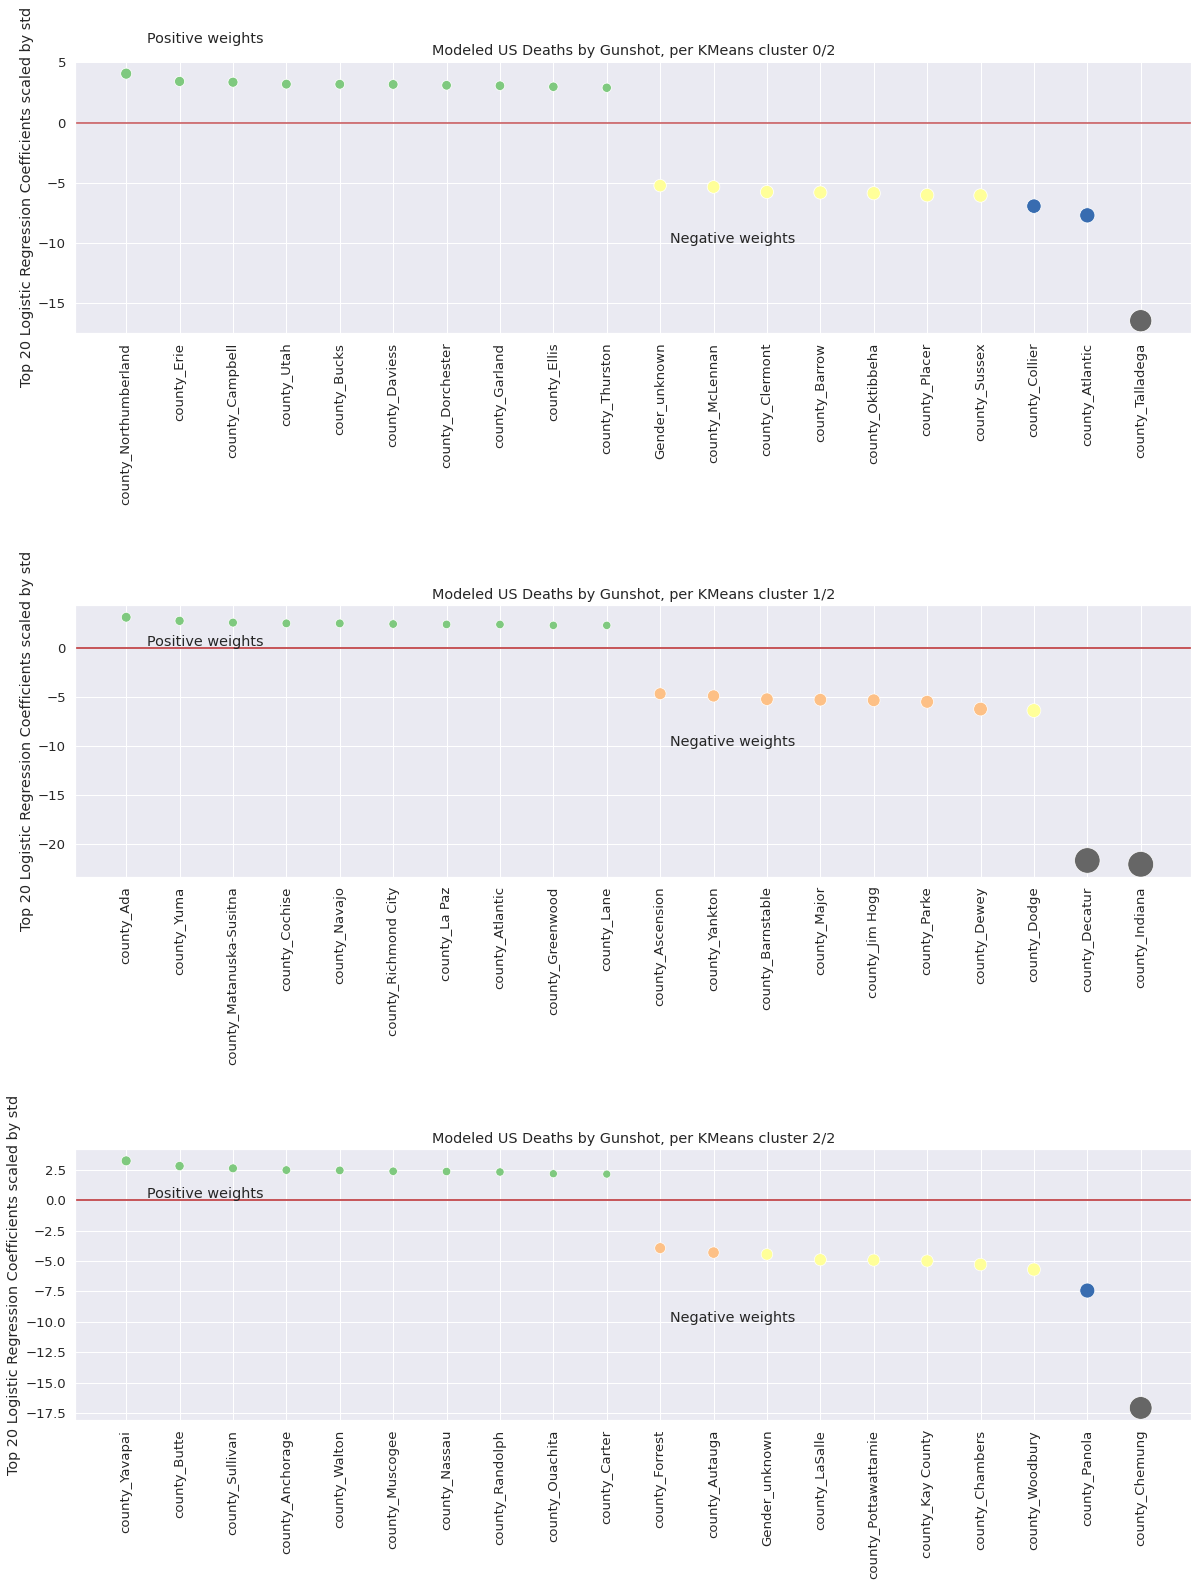

In [29]:
coefficientsc0=grid_c0.best_estimator_.coef_.tolist()
coefficientsc1=grid_c1.best_estimator_.coef_.tolist()
coefficientsc2=grid_c2.best_estimator_.coef_.tolist()
featuresc0=cluster0.columns
featuresc1=cluster1.columns
featuresc2=cluster2.columns
c0_df=pd.DataFrame()
c1_df=pd.DataFrame()
c2_df=pd.DataFrame()
c0_df['Feature'] = featuresc0
c1_df['Feature'] = featuresc1
c2_df['Feature'] = featuresc2
c0_df['Coefficients']=coefficientsc0[0] * np.std(X_trainc0, 0)
c1_df['Coefficients'] = coefficientsc1[0] * np.std(X_trainc1, 0)
c2_df['Coefficients'] = coefficientsc2[0] * np.std(X_trainc2, 0)
c0_df=c0_df.sort_values(by='Coefficients', ascending=False)
c1_df = c1_df.sort_values(by='Coefficients', ascending=False)
c2_df = c2_df.sort_values(by='Coefficients', ascending=False)
top_featuresc0=pd.concat([c0_df.head(10), c0_df.tail(10)], axis=0)
top_featuresc1=pd.concat([c1_df.head(10), c1_df.tail(10)], axis=0)
top_featuresc2=pd.concat([c2_df.head(10), c2_df.tail(10)], axis=0)
fig, axs = plt.subplots(3,figsize=(20,25))
sns.set_style("whitegrid")
sns.scatterplot(data=top_featuresc0, x='Feature',y='Coefficients', hue=top_featuresc0['Coefficients'],s=np.abs(top_featuresc0['Coefficients']*30),palette='Accent_r',legend=False,ax=axs[0])
sns.scatterplot(data=top_featuresc1, x='Feature',y='Coefficients', hue=top_featuresc1['Coefficients'],s=np.abs(top_featuresc1['Coefficients']*30),palette='Accent_r',legend=False,ax=axs[1])
sns.scatterplot(data=top_featuresc2, x='Feature',y='Coefficients', hue=top_featuresc2['Coefficients'],s=np.abs(top_featuresc2['Coefficients']*30),palette='Accent_r',legend=False,ax=axs[2])
sns.set(font_scale=1.2)
axs[0].title.set_text("Modeled US Deaths by Gunshot, per KMeans cluster 0/2")
axs[1].title.set_text("Modeled US Deaths by Gunshot, per KMeans cluster 1/2")
axs[2].title.set_text("Modeled US Deaths by Gunshot, per KMeans cluster 2/2")
axs[0].set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
axs[0].annotate("Positive weights", xy=(0.2,0), xytext=(10, 80), textcoords='offset points', )
axs[0].annotate("Negative weights", xy=(10,-10), xytext=(10, 0), textcoords='offset points', )
axs[1].set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
axs[1].annotate("Positive weights", xy=(0.2,0.2), xytext=(10, 0), textcoords='offset points', )
axs[1].annotate("Negative weights", xy=(10,-10), xytext=(10, 0), textcoords='offset points', )
axs[1].axhline(0,0,1, color='r')
axs[2].set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
axs[2].annotate("Positive weights", xy=(0.2,0.2), xytext=(10, 0), textcoords='offset points', )
axs[2].annotate("Negative weights", xy=(10,-10), xytext=(10, 0), textcoords='offset points', )
axs[2].axhline(0,0,1, color='r')
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)
axs[0].axhline(0,0,1,color='r')
axs[1].axhline(0,0,1,color='r')
axs[2].axhline(0,0,1,color='r')
axs[0].set(xlabel=None)
axs[1].set(xlabel=None)
axs[2].set(xlabel=None)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)
plt.subplots_adjust(hspace = 1)
plt.show()

#<font color='teal'>These results indicate that data seem to be too localized to model reliably using nationwide data. </font> 
## Now at state level, weighted logistic regression with GridSearchCV on <font color='teal'>Texas </font> show that the problematic recall value on the test set improves in the minority case, but falls in the majority:

In [15]:
TXL_X = df[df.st=='TX'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
TXL_y = (df[(df.st=='TX')][['Cause']]['Cause']=='Gunshot')*1
TXL_X = pd.get_dummies(TXL_X, drop_first=True)
cols=TXL_X.columns
oversample2 = SMOTE()
TXL_X, TXL_y = oversample2.fit_resample(TXL_X, TXL_y)
TXL_X = pd.DataFrame(TXL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(TXL_X,TXL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf2=LogisticRegression(max_iter=10000)
grid2 = GridSearchCV(clf2,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid2.fit(X_train,y_train)
y_pred2train = grid2.predict(X_train)
print(grid2.best_params_)
print(classification_report(y_train, y_pred2train, zero_division=1))
y_pred2test = grid2.predict(X_test)
print(grid2.best_params_)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred2test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred2test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred2test)}')
print(classification_report(y_test, y_pred2test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 100, 'class_weight': {0: 80, 1: 20}}
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1053
           1       0.98      0.52      0.68      1069

    accuracy                           0.75      2122
   macro avg       0.83      0.76      0.74      2122
weighted avg       0.83      0.75      0.74      2122

{'C': 100, 'class_weight': {0: 80, 1: 20}}
Test Accuracy Score: 0.6483050847457628
Test Confusion Matrix: 
[[339 377]
 [121 579]]
Test Area Under Curve: 0.6503032721468476
              precision    recall  f1-score   support

           0       0.74      0.47      0.58       716
           1       0.61      0.83      0.70       700

    accuracy                           0.65      1416
   macro avg       0.67      0.65      0.64      1416
weighted avg       0.67      0.65      0.64      1416



## <font color='teal'>Texas </font> results show that the highest positive weight corresponds to an encounter with the US Customs and Border Protection followed by the El Paso Police Department, and that the highest weight by far is negative and associated with Bedford City, a city with a population of about 50K just outside of Fort Worth, Texas:

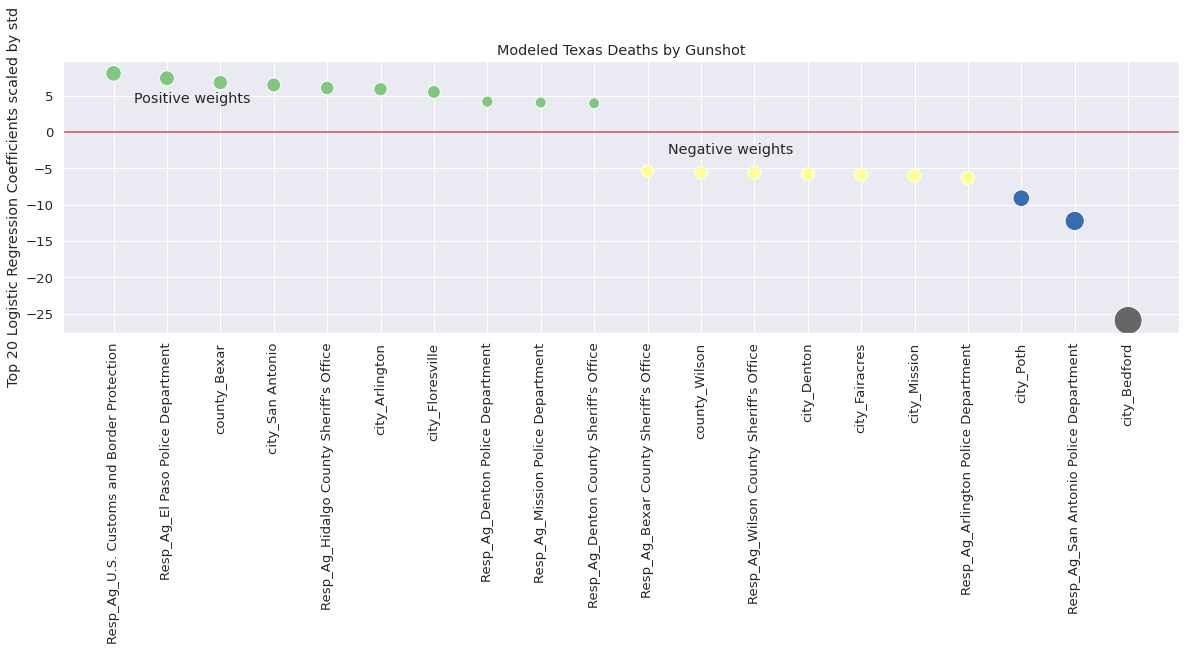

In [27]:
coefficients=grid2.best_estimator_.coef_.tolist()
features=TXL_X.columns
TX_df=pd.DataFrame()
TX_df['Feature'] = features
TX_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
TX_df = TX_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([TX_df.head(10), TX_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(20, 5))
ax=sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*30),palette='Accent_r', legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0,-7), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-14), xytext=(20, 80), textcoords='offset points', )
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.title("Modeled Texas Deaths by Gunshot")
plt.xticks(rotation=90)
plt.show()

## In <font color='teal'>California, </font> modeling shows much better results on the test set in both classes:

In [29]:
w=[{0:73,1:27},{0:60,1:40}, {0:50,1:50}, 
     {0:80,1:20}, {0:90,1:10} ]
hyperparam_grid = {"class_weight": w, 'C':[0.001, 0.1, 1, 10, 100]}
CAL_X = df[df.st=='CA'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
CAL_y = (df[(df.st=='CA')][['Cause']]['Cause']=='Gunshot')*1
CAL_X = pd.get_dummies(CAL_X, drop_first=True)
cols=CAL_X.columns
oversample3 = SMOTE()
CAL_X, CAL_y = oversample3.fit_resample(CAL_X, CAL_y)
CAL_X = pd.DataFrame(CAL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(CAL_X,CAL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf3=LogisticRegression(max_iter=10000)
grid3 = GridSearchCV(clf3,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid3.fit(X_train,y_train)
y_pred3train = grid3.predict(X_train)
print(grid3.best_params_)
print(classification_report(y_train, y_pred3train, zero_division=1))
y_pred3test = grid3.predict(X_test)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred3test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred3test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred3test)}')
print(grid3.best_params_)
print(classification_report(y_test, y_pred3test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1994
           1       1.00      0.40      0.57      1992

    accuracy                           0.70      3986
   macro avg       0.81      0.70      0.67      3986
weighted avg       0.81      0.70      0.67      3986

Test Accuracy Score: 0.6075996990218209
Test Confusion Matrix: 
[[1285   43]
 [1000  330]]
Test Area Under Curve: 0.6078703913397954
{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.56      0.97      0.71      1328
           1       0.88      0.25      0.39      1330

    accuracy                           0.61      2658
   macro avg       0.72      0.61      0.55      2658
weighted avg       0.72      0.61      0.55      2658



## <font color='teal'>California </font> results show that the highest positive weight corresponds to being male, followed by the San Diego County Sheriff's Office. The lowest negative weights correspond to the California Highway Patrol.

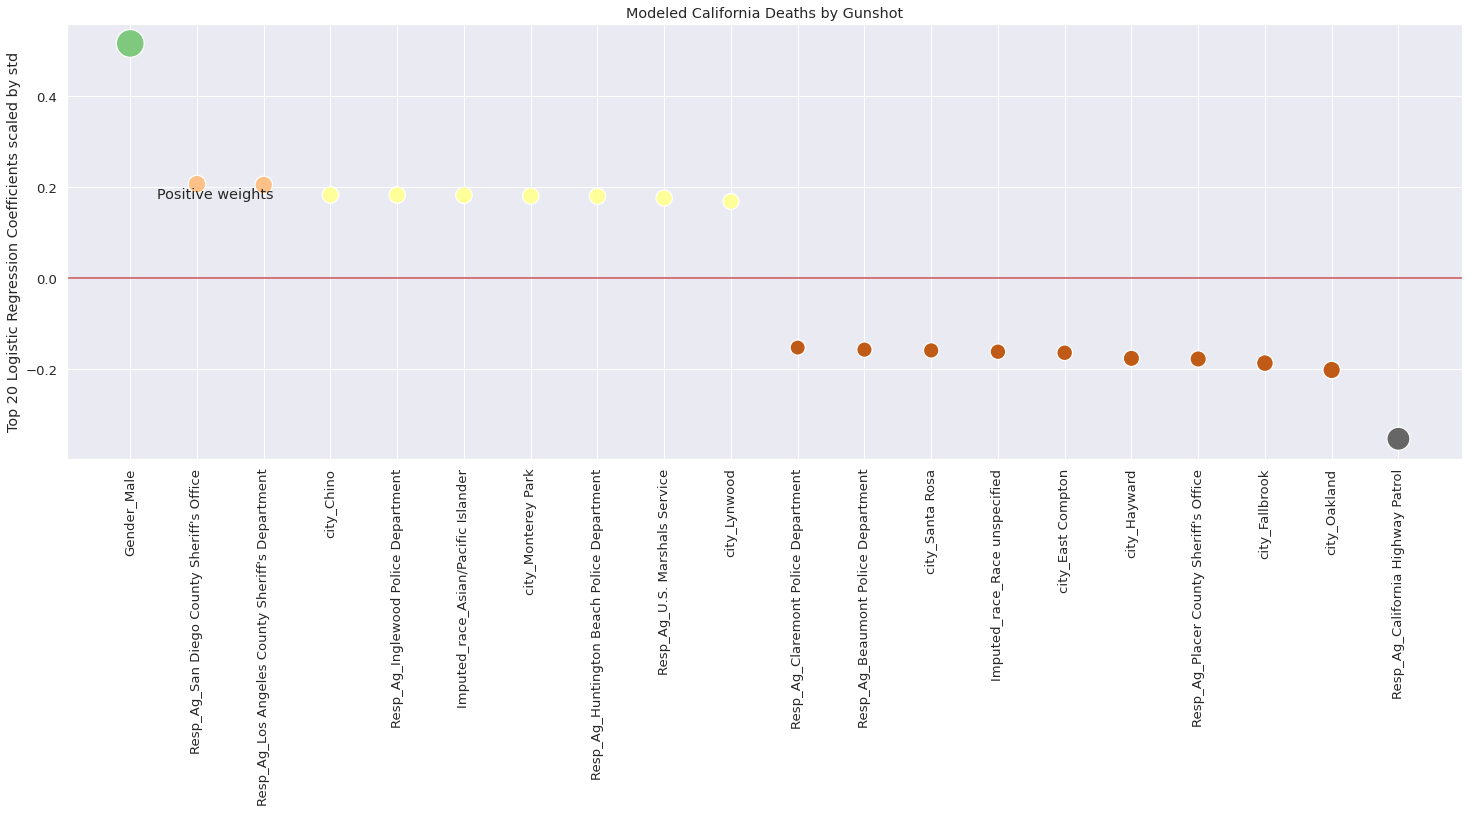

In [31]:
coefficients=grid3.best_estimator_.coef_.tolist()
features=CAL_X.columns
CA_df=pd.DataFrame()
CA_df['Feature'] = features
CA_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
CA_df = CA_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([CA_df.head(10), CA_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 8))
ax=sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*1500),palette='Accent_r', legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.1,0), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-1), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled California Deaths by Gunshot")
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

## In <font color='teal'>Florida, </font> modeling performed poorly on the positive test set:

In [33]:
FLL_X = df[df.st=='FL'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
FLL_y = (df[(df.st=='FL')][['Cause']]['Cause']=='Gunshot')*1
FLL_X = pd.get_dummies(FLL_X, drop_first=True)
cols=FLL_X.columns
oversample4 = SMOTE()
FLL_X, FLL_y = oversample4.fit_resample(FLL_X, FLL_y)
FLL_X = pd.DataFrame(FLL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(FLL_X,FLL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf4=LogisticRegression(max_iter=10000)
grid4 = GridSearchCV(clf4,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) 
grid4.fit(X_train,y_train)
y_pred4train = grid4.predict(X_train)
print(grid4.best_params_)
print(classification_report(y_train, y_pred4train, zero_division=1))
y_pred4test = grid4.predict(X_test)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred4test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred4test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred4test)}')
print(grid4.best_params_)
print(classification_report(y_test, y_pred4test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       771
           1       1.00      0.39      0.56       798

    accuracy                           0.69      1569
   macro avg       0.81      0.70      0.66      1569
weighted avg       0.81      0.69      0.66      1569

Test Accuracy Score: 0.6294173829990449
Test Confusion Matrix: 
[[529   8]
 [380 130]]
Test Area Under Curve: 0.6200021908204623
{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.58      0.99      0.73       537
           1       0.94      0.25      0.40       510

    accuracy                           0.63      1047
   macro avg       0.76      0.62      0.57      1047
weighted avg       0.76      0.63      0.57      1047



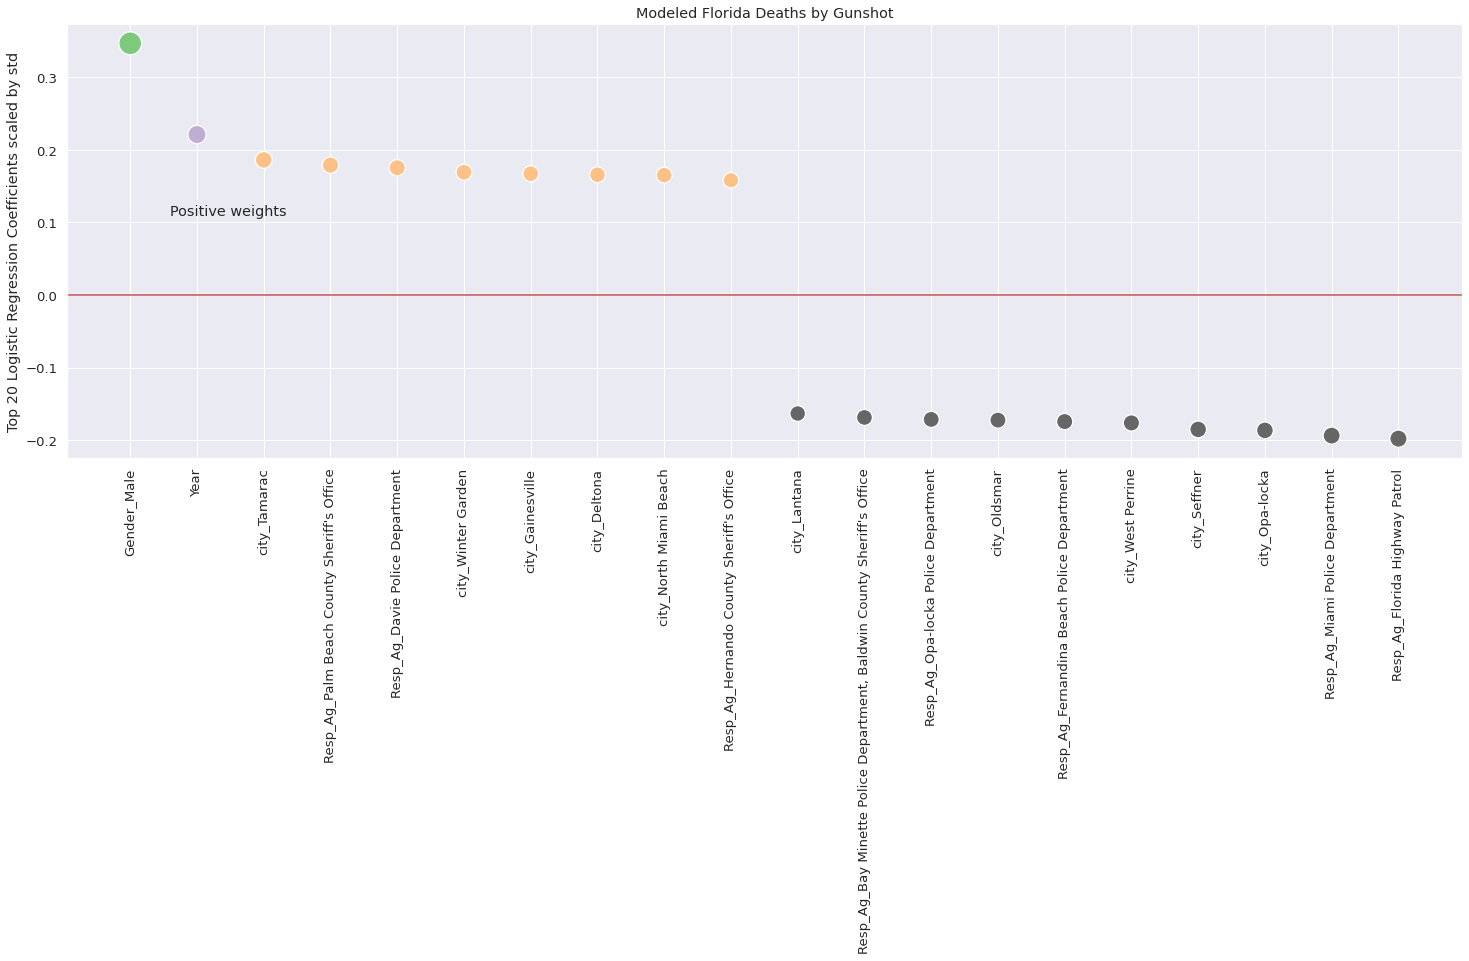

In [35]:
coefficients=grid4.best_estimator_.coef_.tolist()
features=FLL_X.columns
FL_df=pd.DataFrame()
FL_df['Feature'] = features
FL_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
FL_df = FL_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([FL_df.head(10), FL_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 8))
ax=sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*1500),palette='Accent_r', legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.3,0), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-1), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled Florida Deaths by Gunshot")
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

## <font color='teal'>Arizona </font> results show a lower recall value in the majority test set of 1, but still an improvement over the base model.

In [40]:
AZL_X = df[df.st=='AZ'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
AZL_y = (df[(df.st=='AZ')][['Cause']]['Cause']=='Gunshot')*1
AZL_X = pd.get_dummies(AZL_X, drop_first=True)
cols=AZL_X.columns
oversample5 = SMOTE()
AZL_X, AZL_y = oversample5.fit_resample(AZL_X, AZL_y)
AZL_X = pd.DataFrame(AZL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(AZL_X,AZL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf5=LogisticRegression(max_iter=10000)
grid5 = GridSearchCV(clf5,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid5.fit(X_train,y_train)
y_pred5train = grid5.predict(X_train)
print(grid5.best_params_)
print(classification_report(y_train, y_pred5train, zero_division=1))
y_pred5test = grid5.predict(X_test)
print(grid5.best_params_)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred5test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred5test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred5test)}')
print(classification_report(y_test, y_pred5test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       432
           1       1.00      0.36      0.53       430

    accuracy                           0.68       862
   macro avg       0.81      0.68      0.65       862
weighted avg       0.81      0.68      0.65       862

{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
Test Accuracy Score: 0.5850694444444444
Test Confusion Matrix: 
[[287   0]
 [239  50]]
Test Area Under Curve: 0.5865051903114187
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       287
           1       1.00      0.17      0.29       289

    accuracy                           0.59       576
   macro avg       0.77      0.59      0.50       576
weighted avg       0.77      0.59      0.50       576



## Like California and Florida, <font color='teal'>Arizona </font> results show that the highest positive weight corresponds to being male. The next highest positive weight is the year when the death occurred, followed by a connection to the Mesa Police department. The lowest negative weights correspond to the Navajo Nation police.

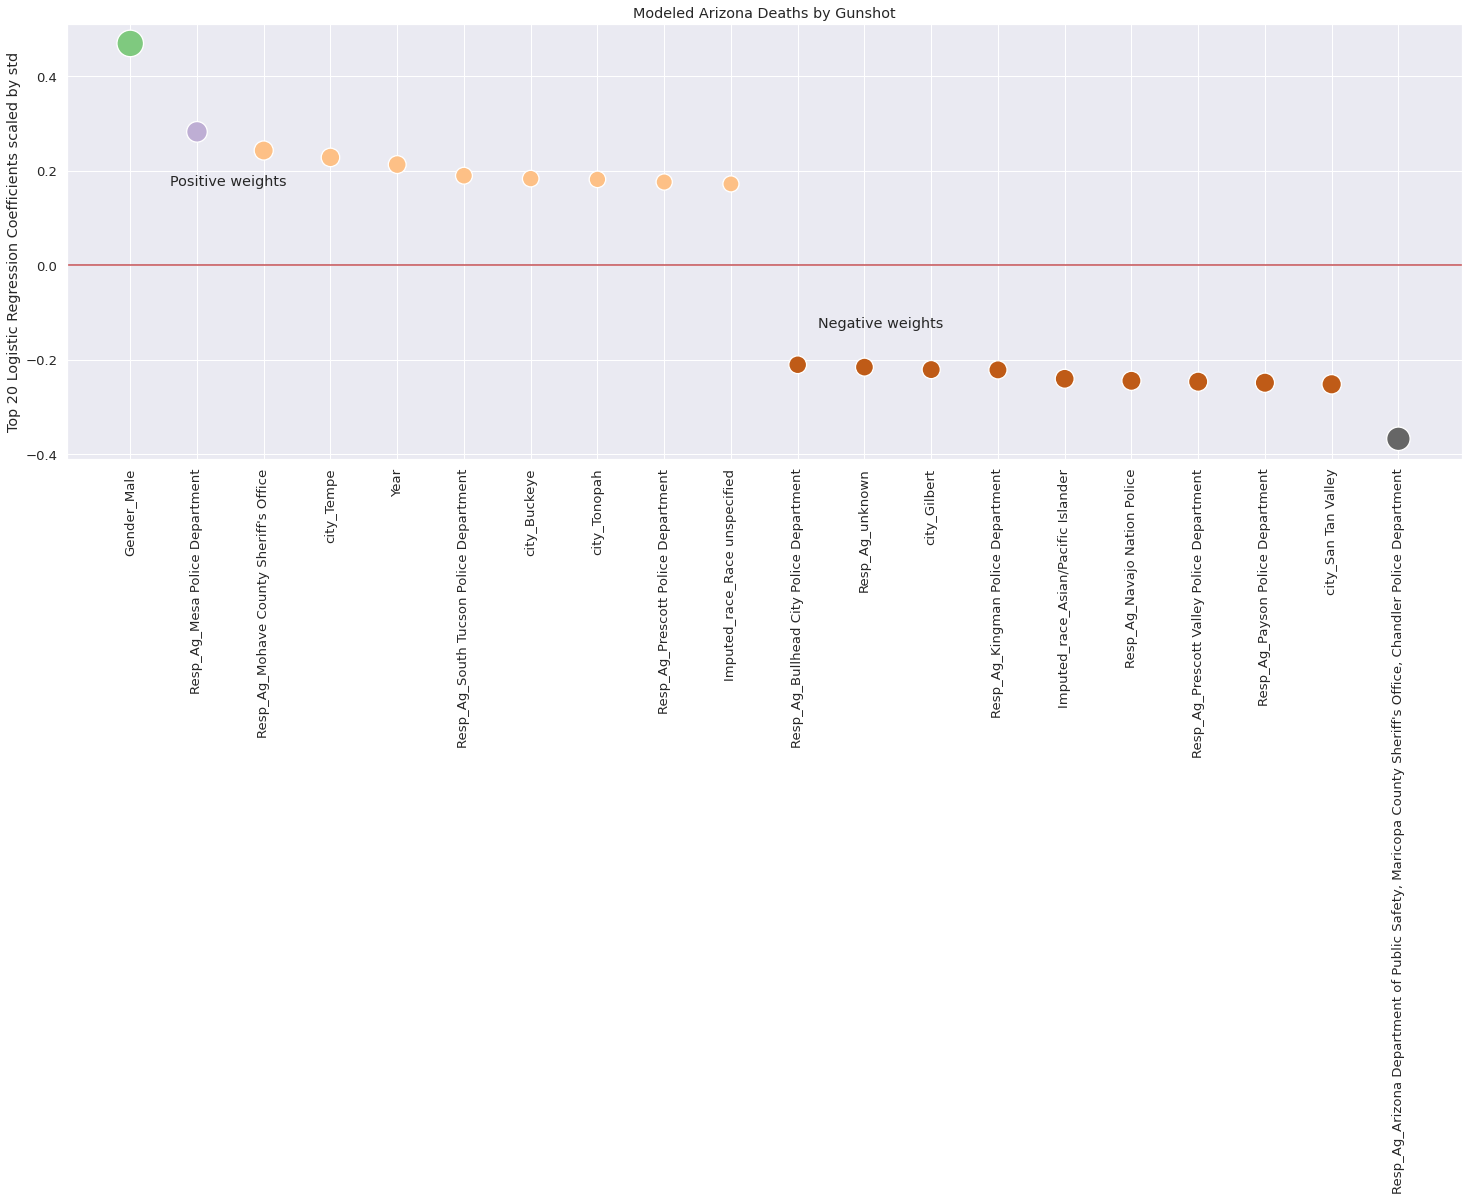

In [39]:
coefficients=grid5.best_estimator_.coef_.tolist()
features=AZL_X.columns
AZ_df=pd.DataFrame()
AZ_df['Feature'] = features
AZ_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
AZ_df = AZ_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([AZ_df.head(10), AZ_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 8))
sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*1500),palette='Accent_r',legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.3,0), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-0.3), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled Arizona Deaths by Gunshot")
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

## <font color='teal'>New York </font> results also show a lower recall value in the majority test set of 1, but still an improvement over the base model.

In [41]:
NYL_X = df[df.st=='NY'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
NYL_y = (df[(df.st=='NY')][['Cause']]['Cause']=='Gunshot')*1
NYL_X = pd.get_dummies(NYL_X, drop_first=True)
cols=NYL_X.columns
oversample6 = SMOTE()
NYL_X, NYL_y = oversample6.fit_resample(NYL_X, NYL_y)
NYL_X = pd.DataFrame(NYL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(NYL_X,NYL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf6=LogisticRegression(max_iter=10000)
grid6 = GridSearchCV(clf6,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid6.fit(X_train,y_train)
y_pred6train = grid6.predict(X_train)
print(grid6.best_params_)
print(classification_report(y_train, y_pred6train, zero_division=1))
y_pred6test = grid6.predict(X_test)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred6test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred6test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred6test)}')
print(grid6.best_params_)
print(classification_report(y_test, y_pred6test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       263
           1       1.00      0.35      0.52       281

    accuracy                           0.67       544
   macro avg       0.80      0.68      0.63       544
weighted avg       0.80      0.67      0.63       544

Test Accuracy Score: 0.5686813186813187
Test Confusion Matrix: 
[[189   2]
 [155  18]]
Test Area Under Curve: 0.5467875192930424
{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       191
           1       0.90      0.10      0.19       173

    accuracy                           0.57       364
   macro avg       0.72      0.55      0.45       364
weighted avg       0.72      0.57      0.46       364



## Like California and Arizona,<font color='teal'> New York </font> results show that the highest positive weight corresponds to being male. In the lowest negative weights is Age, which was different from the other states. The lowest negative weight corresponds to the Yonkers Police Department.

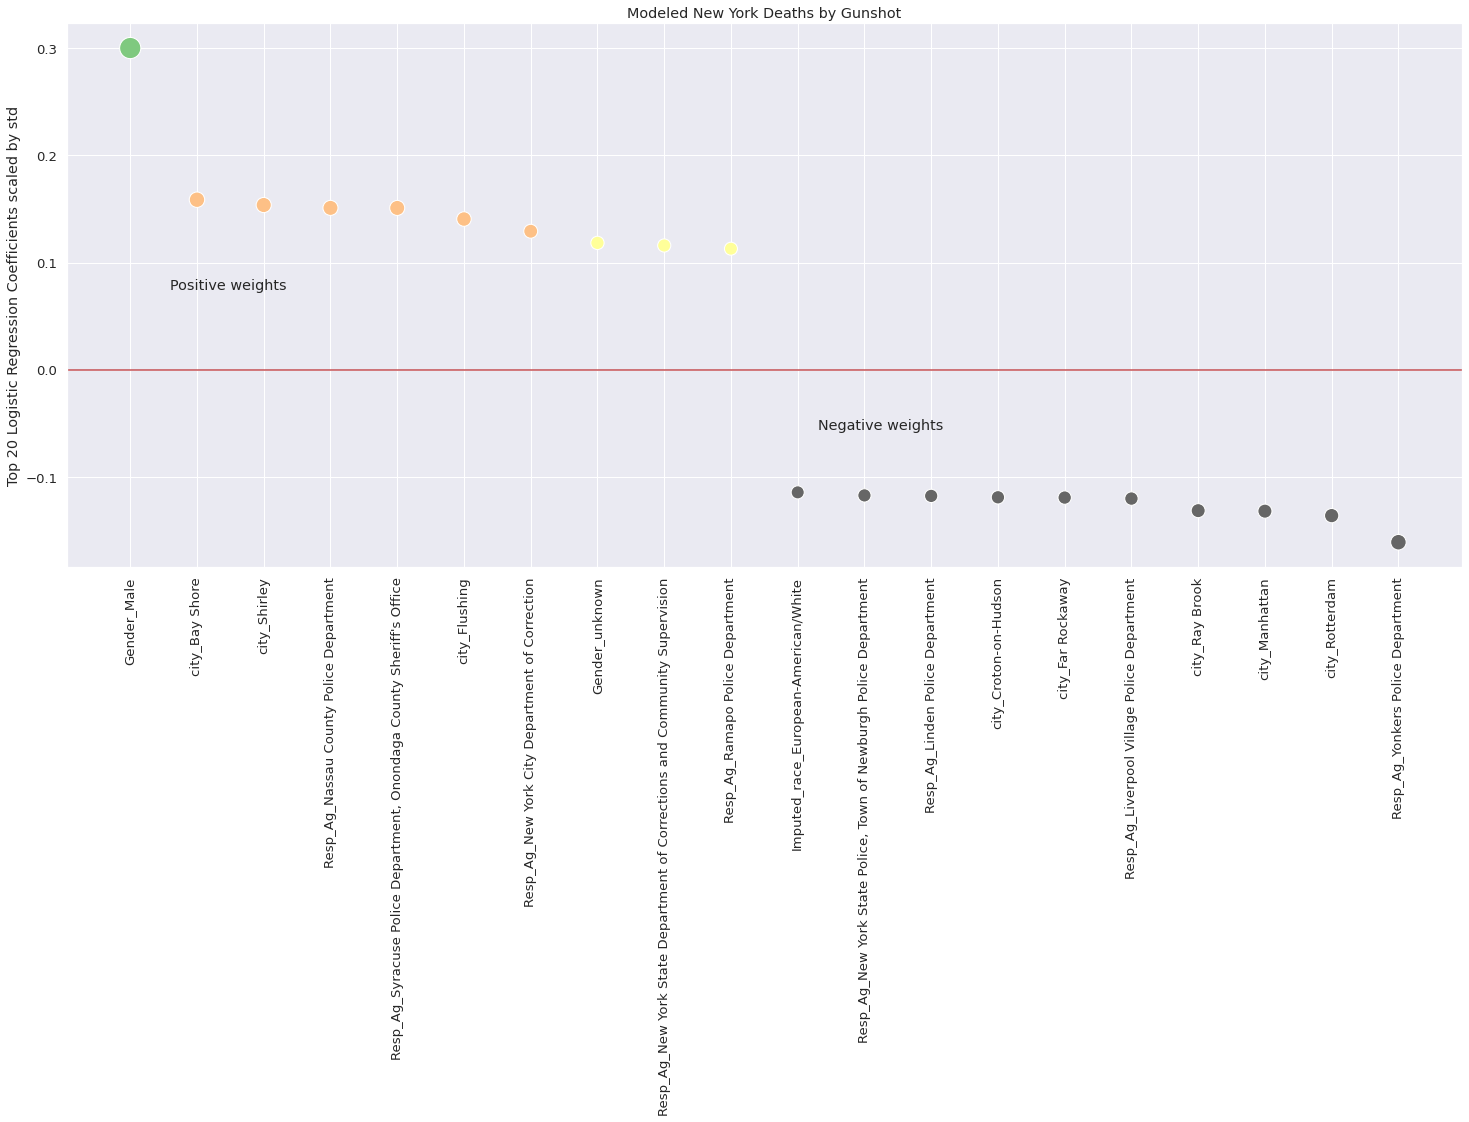

In [52]:
coefficients=grid6.best_estimator_.coef_.tolist()
features=NYL_X.columns
NY_df=pd.DataFrame()
NY_df['Feature'] = features
NY_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
NY_df = NY_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([NY_df.head(10), NY_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*1500),palette='Accent_r',legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.3,0), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-0.13), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled New York Deaths by Gunshot")
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

GA

In [54]:
GAL_X = df[df.st=='GA'][['Age','Gender','Imputed_race','Resp_Ag','city','county','Year']].dropna()
GAL_y = (df[(df.st=='GA')][['Cause']]['Cause']=='Gunshot')*1
GAL_X = pd.get_dummies(GAL_X, drop_first=True)
cols=GAL_X.columns
oversample7 = SMOTE()
GAL_X, GAL_y = oversample6.fit_resample(GAL_X, GAL_y)
GAL_X = pd.DataFrame(GAL_X, columns = cols)
X_train, X_test, y_train, y_test = train_test_split(GAL_X,GAL_y,test_size=0.4,random_state=123)
X_train=scale(X_train)
X_test=scale(X_test)
clf7=LogisticRegression(max_iter=10000)
grid7 = GridSearchCV(clf7,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True) #without PCA
grid7.fit(X_train,y_train)
y_pred7train = grid7.predict(X_train)
print(grid7.best_params_)
print(classification_report(y_train, y_pred7train, zero_division=1))
y_pred7test = grid7.predict(X_test)
print(f'Test Accuracy Score: {accuracy_score(y_test,y_pred7test)}')
print(f'Test Confusion Matrix: \n{confusion_matrix(y_test, y_pred7test)}')
print(f'Test Area Under Curve: {roc_auc_score(y_test, y_pred7test)}')
print(grid7.best_params_)
print(classification_report(y_test, y_pred7test, zero_division=1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       459
           1       1.00      0.58      0.73       450

    accuracy                           0.79       909
   macro avg       0.85      0.79      0.78       909
weighted avg       0.85      0.79      0.78       909

Test Accuracy Score: 0.6326194398682042
Test Confusion Matrix: 
[[288  11]
 [212  96]]
Test Area Under Curve: 0.6374495070147245
{'C': 0.001, 'class_weight': {0: 90, 1: 10}}
              precision    recall  f1-score   support

           0       0.58      0.96      0.72       299
           1       0.90      0.31      0.46       308

    accuracy                           0.63       607
   macro avg       0.74      0.64      0.59       607
weighted avg       0.74      0.63      0.59       607



GA

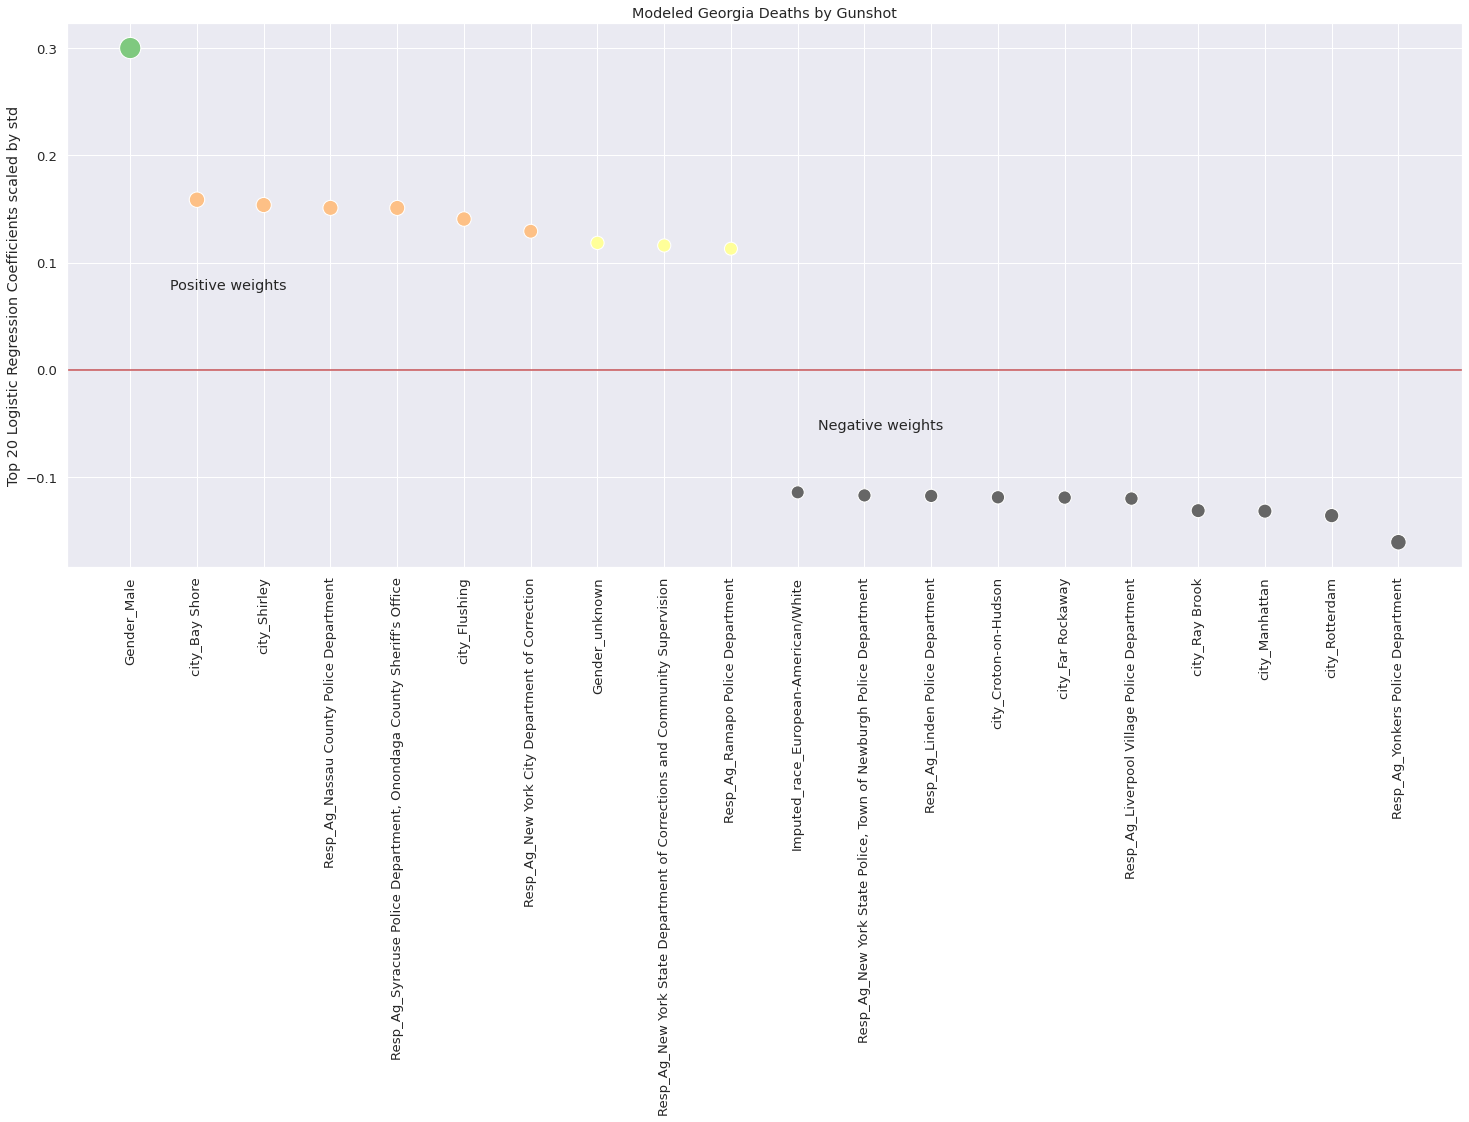

In [55]:
coefficients=grid7.best_estimator_.coef_.tolist()
features=GAL_X.columns
GA_df=pd.DataFrame()
GA_df['Feature'] = features
GA_df['Coefficients'] = coefficients[0] * np.std(X_train, 0)
GA_df = NY_df.sort_values(by='Coefficients', ascending=False)
top_features=pd.concat([GA_df.head(10), GA_df.tail(10)], axis=0)
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(data=top_features, x='Feature',y='Coefficients', hue=top_features['Coefficients'],s=np.abs(top_features['Coefficients']*1500),palette='Accent_r',legend=False)
sns.set(font_scale=1.2)
ax.set(ylabel='Top 20 Logistic Regression Coefficients scaled by std')
ax.annotate("Positive weights", xy=(0.3,0), xytext=(20, 80), textcoords='offset points', )
ax.annotate("Negative weights", xy=(10,-0.13), xytext=(20, 80), textcoords='offset points', )
plt.title("Modeled Georgia Deaths by Gunshot")
ax.set(xlabel=None)
ax.axhline(0,0,1,color='r')
plt.xticks(rotation=90)
plt.show()

#<font color='teal'> Summary </font>
## In light of the errors in modeling, only the largest weights should be considered as indicative of feature importance. Using the metrics of Test Accuracy and AUC, the individual states give slightly better results than the base model or extended model. In GA, NY, AZ, FL and CA, the highest weight was positive with the male gender, while in TX it was negative with the City of Bedford, a small town outside of Fort Worth. 

#<font color='teal'> Potential Future Work </font>
It may be possible to decrease errors in modeling by using even more localized data at a county or city level. A rich source of information exists within the Descriptions that could provide many insights using Natural Language Processing. Time series analysis could also be insightful to understand the locations from where the increase in fatal encounters happens nationally.